In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("C:/Users/Anshika/Downloads/cloudcredits/creditcard.csv")

# Scale 'Amount' and drop 'Time'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop(['Time'], axis=1, inplace=True)

# Check class distribution
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


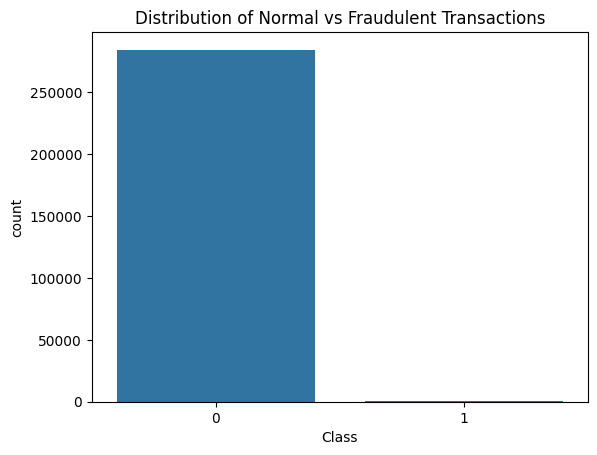

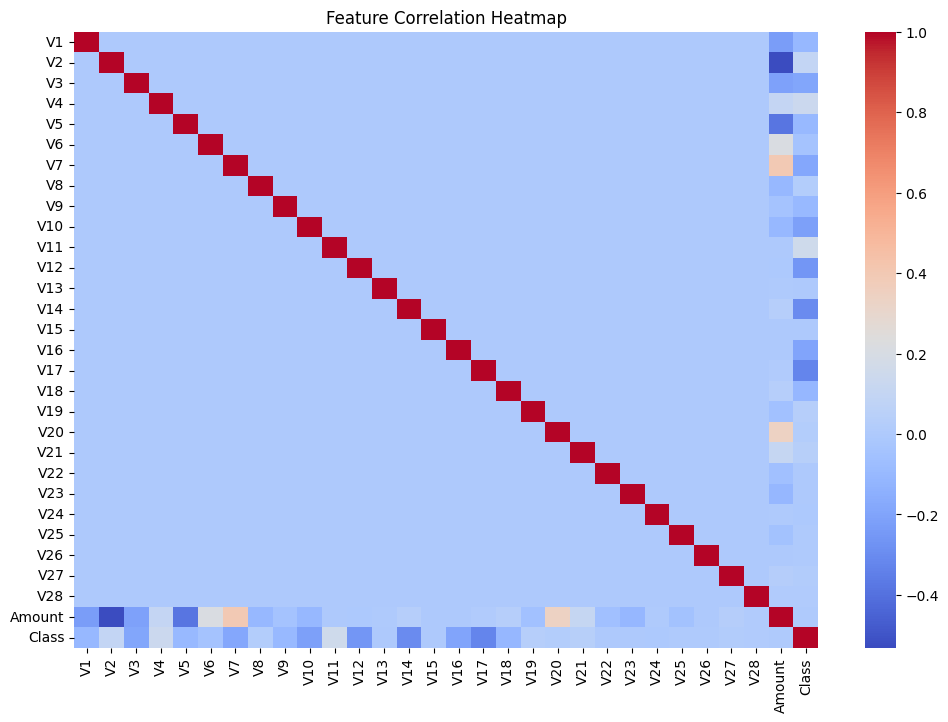

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
sns.countplot(x='Class', data=df)
plt.title("Distribution of Normal vs Fraudulent Transactions")
plt.show()

# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [3]:
# Already anonymized and PCA-transformed features present (V1–V28)
# We'll use all of them except 'Time' which we already dropped.
features = [col for col in df.columns if col != 'Class']

In [7]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[85290     5]
 [   35   113]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.76      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [9]:
from keras.models import Model
from keras.layers import Input, Dense
import numpy as np

input_dim = X_train.shape[1]
encoding_dim = 14  # compression

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True)

# Reconstruction error
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Thresholding for fraud
threshold = np.percentile(mse, 99.5)
y_pred_auto = (mse > threshold).astype(int)

print(classification_report(y_test, y_pred_auto))

Epoch 1/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.9439
Epoch 2/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8201
Epoch 3/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8141
Epoch 4/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.7872
Epoch 5/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8048
Epoch 6/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.8050
Epoch 7/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.8164
Epoch 8/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.8165
Epoch 9/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8003
Epoch 10/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.8188
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.14      0.41      0.21       148

    accuracy                           0.99     85443
   macro avg       0.57      0.70     

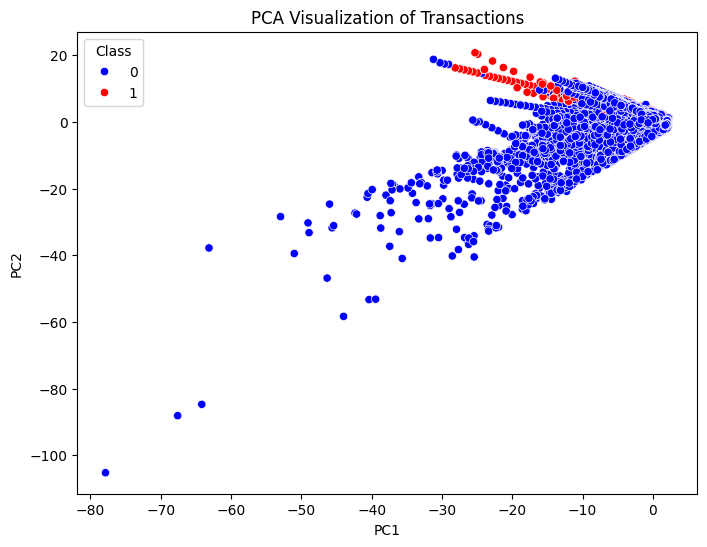

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y, palette=["blue", "red"])
plt.title("PCA Visualization of Transactions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()